**IMPORTING NECESSARY LIBERARIES AND INITIALIZING API KEYS**

In [79]:
SEARCH_ENGINE_ID="YOUR SEARCH_ENGINE_ID"
GOOGLE_API_KEY="YOUR GOOGLE_API_KEY"
GEMINI_API_KEY="YOUR GEMINI_API_KEY"

In [80]:
!pip install folium geotext geopy

In [81]:
import requests
from google.colab import files
import re
from bs4 import BeautifulSoup
import json
import google.generativeai as genai
import folium
from geopy.geocoders import Nominatim
import time
from IPython.display import IFrame
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**DEFINING INSTRUCTION LIBERARY**


1.   search_news : Searches and saves URLs locally.
2.   save_news : Stores relevant articles locally
3.   lda_from_article : Performs LDA and saves results in a new file
4.   initial_summary :  Creates and saves a summary of each article in a single file.
5. extract_info : Extracts article number, date, LDA, and locations, then saves them.
6. combine_summary : Generates a combined summary of all articles.
7. visualize_locations : Plots extracted locations on a world map.
8. visualize_article_counts : Creates a date vs. article count plot.
9. visualize_plot_trends :Visualizes LDA information trends.



In [82]:
def search_news(search_query, google_api_key, search_engine_id):
    # Searches for news articles using Google Custom Search API and saves URLs locally.

    print("Action: Search and Save news URLs")
    print(f"Searching for: {search_query}")

    # Construct API request URL and get JSON response.
    url = f"https://www.googleapis.com/customsearch/v1?key={google_api_key}&cx={search_engine_id}&q={search_query}"
    response = requests.get(url).json()

    # Extract URLs from response; defaults to an empty list if no items are found.
    urls = [item['link'] for item in response.get('items', [])]

    file_name = "extracted_urls.txt"

    # Save extracted URLs to a file.
    with open(file_name, "w") as file:
        if urls:
            file.write("\n".join(urls))
            print(f"Extracted {len(urls)} URLs and saved to '{file_name}'.")
        else:
            print("No URLs found.")

    # Trigger download of the saved file.
    files.download(file_name)


In [83]:
# Extracts articles from provided news URLs and saves the content locally.
def save_news(file_path):
    print("Action: Save news articles")
    print("Action Input: File containing extracted URLs")

    def clean(text):
        cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple whitespace with a single space.
        cleaned_text = re.sub(r'[^a-zA-Z0-9,.!?\s]', '', cleaned_text)  # Remove unwanted characters.
        return cleaned_text.strip()  # Strip leading/trailing whitespace.

    articles_content = []

    with open(file_path, 'r') as f:
        urls = f.read().splitlines()

    for index, url in enumerate(urls):
        try:
            resp = requests.get(url)
            soup = BeautifulSoup(resp.content, 'html.parser')

            date_info = soup.find('script', type='application/ld+json')
            date_text = 'Date not found'

            if date_info:
                json_data = json.loads(date_info.string)
                if isinstance(json_data, list):
                    for item in json_data:
                        if 'datePublished' in item:
                            date_text = item['datePublished']
                elif isinstance(json_data, dict) and 'datePublished' in json_data:
                    date_text = json_data['datePublished']

            content = soup.find('article').get_text() if soup.find('article') else 'No content found'
            cleaned_content = clean(content)
            articles_content.append(f"Article {index + 1}\nURL: {url}\nDate: {date_text}\nContent:\n{cleaned_content}\n")
        except Exception as e:
            print(f"Failed to parse {url}: {e}")

    with open("articles.txt", "w") as file:
        file.write("\n".join(articles_content))

    files.download("articles.txt")


In [84]:
# Extracts LDA information from articles and saves it in a file.
def lda_from_articles(file_path):
    print("Action: Extract LDA information for the articles")
    print("Action Input: File containing articles")

    custom_stopwords = set(stopwords.words('english')).union({
        "said", "would", "could", "may", "also", "one", "two", "three",
        "time", "people", "like", "get", "new", "know", "make", "take",
        "can", "see", "us", "there", "this", "just", "it", "its", "are"
    })

    def preprocess_article(content):
        content = re.sub(r'[^\w\s]', '', content)  # Remove punctuation.
        tokens = word_tokenize(content.lower())  # Tokenize and convert to lowercase.
        filtered_tokens = [
            word for word in tokens
            if word.isalpha() and word not in custom_stopwords and len(word) > 2
        ]
        return filtered_tokens

    with open(file_path, 'r') as f:
        articles = f.read().split('\n\n')  # Split articles by double newlines.

    processed_articles = []
    summaries = []

    for index, article_block in enumerate(articles):
        try:
            article_lines = article_block.split('\n')
            url = article_lines[1].replace("URL: ", "")
            date = article_lines[2].replace("Date: ", "")
            content = re.sub(r'\s+', ' ', "\n".join(article_lines[3:])).strip()

            if "No content found" in content or "Date not found" in date:
                continue  # Skip articles with missing content or date.

            processed_articles.append(content)
            summaries.append((index, url, date, content))

        except Exception:
            continue  # Ignore errors and continue with the next article.

    tokens = [preprocess_article(article) for article in processed_articles]
    dictionary = corpora.Dictionary(tokens)  # Create a dictionary from tokens.
    corpus = [dictionary.doc2bow(token) for token in tokens]  # Create a bag-of-words corpus.

    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)  # Train LDA model.
    lda_topics = lda_model.print_topics()  # Get LDA topics.

    with open("articles_with_lda.txt", "w") as f:
        for index, url, date, content in summaries:
            topic_info = lda_topics[index % len(lda_topics)]  # Assign topics to articles.
            f.write(f"Article {index + 1}\nURL: {url}\nDate: {date}\nLDA Topic: {topic_info[1]}\n {content}\n\n")

    files.download("articles_with_lda.txt")  # Download the output file.


In [85]:
# Summarizes articles and extracts relevant locations.
api_key = GEMINI_API_KEY
genai.configure(api_key=api_key)

def initial_summarize(file_path):
    print("Action: Summarize the articles")
    print("Action Input: File containing articles")
    model = genai.GenerativeModel("gemini-1.5-flash")

    with open(file_path, 'r') as f:
        articles = f.read().split('\n\n')  # Split articles by double newlines.

    valid_articles = []

    # Identify valid articles with sufficient content.
    for index, article_block in enumerate(articles):
        article_lines = article_block.split('\n')

        if len(article_lines) < 4:
            print(f"Skipping article {index + 1} due to insufficient content.")
            continue

        url = article_lines[1].replace("URL: ", "").strip()
        date = article_lines[2].replace("Date: ", "").strip()
        lda_topics = article_lines[3].replace("LDA Topic: ", "").strip()
        content = re.sub(r'\s+', ' ', "\n".join(article_lines[4:])).strip()

        if not content or "No content found" in content:
            print(f"Skipping article {index + 1} due to lack of content.")
            continue

        valid_articles.append((url, date, lda_topics, content))

    # Summarize valid articles.
    summaries = []

    for valid_index, (url, date, lda_topics, content) in enumerate(valid_articles):
        prompt = (
            f"Summarize the following content in a simple, crisp paragraph:\n"
            f"Article {valid_index + 1}\n"
            f"URL: {url}\n"
            f"Date: {date}\n"
            f"LDA Topic: {lda_topics}\n"
            f"Content:\n\n{content}\n\n"
            f"Extract any relevant locations mentioned in the content, including cities, states, and countries. "
            f"Include them in the output under 'Locations:' and make sure to incorporate all statistics and data "
            f"mentioned in the content. Ensure the summary is cohesive and presented as a paragraph without bullet points."
        )

        summary = model.generate_content(prompt).text

        if 'Locations:' in summary:
            location_part = summary.split('Locations:')[1].strip()
            content_summary = summary.split('Locations:')[0].strip()
            summaries.append(
                f"Article {valid_index + 1}\n"
                f"URL: {url}\n"
                f"Date: {date}\n"
                f"LDA Topic: {lda_topics}\n"
                f"Locations:\n{location_part}\n"
                f"Summary:\n{content_summary}\n"
            )
        else:
            summaries.append(
                f"Article {valid_index + 1}\n"
                f"URL: {url}\n"
                f"Date: {date}\n"
                f"LDA Topic: {lda_topics}\n"
                f"Locations:\n\nNo locations found.\n"
                f"Summary:\n{summary}\n"
            )

    with open("summaries.txt", "w") as f:
        f.write("\n".join(summaries))  # Save all summaries to a file.

    files.download("summaries.txt")  # Download the output file.


In [86]:
# Extracts date, LDA topic, and locations from articles and stores them in a separate file.
def extract_info(file_path):
    print("Action: Extract date, LDA, and locations from the articles")
    print("Action Input: File containing articles")

    with open(file_path, 'r') as f:
        content = f.read()  # Read the entire content of the articles.

    articles = content.split("\n\n")  # Split articles by double newlines.
    extracted_data = []

    for article in articles:
        title_match = re.search(r'^(Article \d+)', article)
        date_match = re.search(r'Date:\s*(.+)', article)
        lda_match = re.search(r'LDA Topic:\s*(.+)', article)
        locations_match = re.search(r'Locations:\s*\n([\s\S]+?)(?:\nSummary:|$)', article)

        # Extract title, date, LDA topic, and locations if all are found.
        if title_match and date_match and lda_match and locations_match:
            title = title_match.group(1)
            date = date_match.group(1).strip()
            lda = lda_match.group(1).strip()
            locations = locations_match.group(1).strip().replace('- ', '').replace('\n', ', ')

            extracted_data.append(f"{title}\nDate: {date}\nLDA Topic: {lda}\nLocations: {locations}\n")

    with open("extracted_info.txt", "w") as f:
        f.write("\n".join(extracted_data))  # Save extracted information to a file.

    files.download("extracted_info.txt")  # Download the output file.


In [87]:
# Creates a comprehensive summary and title from article summaries.
def combined_summary(file_path):
    print("Action: Create a final summary")
    print("Action Input: File containing article summaries")

    with open(file_path, 'r') as f:
        summaries = f.read()  # Read all summaries from the input file.

    model = genai.GenerativeModel("gemini-1.5-flash")  # Initialize the generative model.
    prompt = (
        "Craft a compelling title and an informative summary that synthesizes the insights from the following articles into a cohesive response. "
        "Imagine you are answering a specific question about Alzheimer's disease, utilizing key information, relevant statistics, and spatiotemporal data from each article. "
        "Ensure that the summary flows logically and is well-structured, clearly presenting the most critical aspects without framing it as a simple article summary. "
        "Your response should be engaging and thorough, providing a comprehensive understanding of the topic based on the articles provided:\n\n"
        f"{summaries}"  # Include the collected summaries in the prompt.
    )

    response = model.generate_content(prompt)  # Generate the summary and title using the model.
    combined_summary_text = response.text.strip()  # Clean up the response text.

    with open("combined_summary.txt", "w") as f:
        f.write(combined_summary_text)  # Write the final summary to a file.

    files.download("combined_summary.txt")  # Download the output file.


In [88]:
# Draws a world map marking important locations extracted from summaries.
def visualize_locations(file_path):
    print("Action: Draw a world map of important locations")
    print("Action Input: File containing locations (extracted_info.txt)")

    with open(file_path, 'r') as f:
        summary_text = f.read()  # Read the summary text.

    # Extract unique location names.
    potential_locations = re.findall(r'([A-Z][a-z]+(?: [A-Z][a-z]+)*|[A-Z][a-z]+)', summary_text)
    unique_locations = set(potential_locations)

    geolocator = Nominatim(user_agent="city_locator")
    world_map = folium.Map(location=[20.0, 0.0], zoom_start=2)  # Initialize the map.

    for location in unique_locations:
        location_data = geolocator.geocode(location)  # Get coordinates.
        time.sleep(1)  # Respect rate limits.
        if location_data:  # Add marker if found.
            folium.Marker([location_data.latitude, location_data.longitude], popup=location).add_to(world_map)

    world_map_file = "world_map.html"
    world_map.save(world_map_file)  # Save the map.
    print(f"Map saved as {world_map_file}")

    files.download(world_map_file)  # Download the map file.


In [89]:
# Visualizes the number of articles published per month.
def visualize_article_counts(file_path):
    print("Action: Draw a visualization representing articles per month")
    print("Action Input: File containing dates (extracted_info.txt)")

    with open(file_path, 'r') as f:
        summary_text = f.read()  # Read summary text.

    # Extract and convert dates to monthly periods.
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', summary_text)
    dates = pd.to_datetime(dates)
    date_counts = dates.to_period('M').value_counts().sort_index()

    # Create the bar chart.
    plt.figure(figsize=(12, 6))
    date_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Articles per Month')
    plt.xlabel('Month')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.savefig('articles_per_month.png')  # Save the figure.
    files.download('articles_per_month.png')  # Download the image.
    plt.show()  # Display the plot.


In [90]:
# Visualizes the trend of LDA topics related to Alzheimer's disease over time.
def visualize_plot_trend(file_path):
    # Read the summary text from the provided file.
    with open(file_path, 'r') as f:
        summary_text = f.read()

    # Split the summary text into individual articles based on the article numbering.
    articles = re.split(r'Article \d+', summary_text)[1:]
    extracted_data = []

    # Extract date and LDA topic information from each article.
    for article in articles:
        date_match = re.search(r'Date:\s*([\d+-:]+)', article)
        lda_match = re.search(r'LDA Topic:\s*(.*)', article)

        # If both date and LDA topic are found, process the information.
        if date_match and lda_match:
            date = date_match.group(1)
            lda_info_str = lda_match.group(1)
            lda_info = {}

            # Extract LDA topic importance and corresponding words.
            lda_items = re.findall(r'(\d+\.\d+)\*"([^"]+)"', lda_info_str)
            for importance, word in lda_items:
                lda_info[word] = float(importance)

            # Append extracted data (date and LDA information) to the list.
            extracted_data.append({'date': date, 'lda_info': lda_info})

    # Gather all dates and unique LDA topics for analysis.
    dates = [entry['date'] for entry in extracted_data]
    all_topics = {topic for entry in extracted_data for topic in entry['lda_info']}
    lda_values = {topic: [] for topic in all_topics}

    # Populate the lda_values dictionary with topic importance for each date.
    for entry in extracted_data:
        for topic in all_topics:
            lda_values[topic].append(entry['lda_info'].get(topic, 0))

    # Create a DataFrame from the collected LDA values and dates.
    df = pd.DataFrame(lda_values)
    df['date'] = pd.to_datetime(dates)
    df = df.sort_values(by='date')

    # Generate a stacked area plot to visualize trends in topic importance over time.
    plt.figure(figsize=(10, 6))
    plt.stackplot(df['date'], [df[topic] for topic in all_topics], labels=all_topics, alpha=0.8)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
    plt.title("Topics Trend of Alzheimer's Disease Over Time")
    plt.xlabel("Timeline (Date)")
    plt.ylabel("Topic Importance (%)")
    plt.tight_layout()
    plt.show()


**Function which asks Gemini to check if the generated summary is what user asked for**

In [91]:
def check_summary(user_input):
    try:
        # Read the combined summary content from the file.
        with open("combined_summary.txt", "r") as file:
            summary_content = file.read()

        # Create a prompt to check if the summary answers the user's question.
        prompt = (
            f"Given the user question: '{user_input}', I provided the following response: '{summary_content}'. "
            "If my response was close to what user asked, please repeat it verbatim."
        )

        # Generate a response from the model based on the prompt.
        response = model.generate_content(prompt)

        # Check if the response has valid parts.
        if response.parts:
            for candidate in response.candidates:
                generated_text = candidate.content.parts[0].text

                # If the generated text matches the summary content, print it.
                if summary_content in generated_text:
                    print("Correct Response:")
                    print(summary_content)
                else:
                    # If the summary is not correct, ask the model to improve the summary.
                    improvement_prompt = (
                        f"The following response did not sufficiently address the user question: '{user_input}'. "
                        f"Here is the response: '{summary_content}'. "
                        "Please enhance this summary by adding any relevant information or context."
                    )

                    # Generate improved content from the model.
                    improved_response = model.generate_content(improvement_prompt)

                    # Print the improved response.
                    if improved_response.parts:
                        for improved_candidate in improved_response.candidates:
                            improved_text = improved_candidate.content.parts[0].text
                            print("Improved Response:")
                            print(improved_text)
                    else:
                        print("No valid improvement response from the model.")

        else:
            print("No valid response from the model.")

    except Exception as e:
        # Handle any exceptions that occur during processing.
        print(f"An error occurred while processing: {e}")



**Main fucntion:**
Initially decomposed user query into 2 keyswords (search query) pass it to search_news and then calls other functions

Extracted search query: Alzheimer's Cure 

Thought: I need to use the tool “Search and Save news” to find answers to Can you help me to know something new about Alzheimer’s disease cure?
Extracting URLs and saving locally
Action: Search and Save news URLs
Searching for: Alzheimer's Cure 

Extracted 10 URLs and saved to 'extracted_urls.txt'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

URLs extracted and saved successfully.
Thought: Now that URLs are extracted, the next step is to save the articles
Action: Save news articles
Action Input: File containing extracted URLs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Articles saved successfully.
Thought: Now that articles have been saved, it's time to get LDA information from the articles
Action: Extract LDA information for the articles
Action Input: File containing articles


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully extracted LDA information from the articles and saved to a new file
Thought: Now that LDA information has been extracted, it's time to summarize the articles
Action: Summarize the articles
Action Input: File containing articles
Skipping article 10 due to insufficient content.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully summarized the articles and saved to a new file
Thought: Now that the articles have been summarized, it's time to extract date, lda and locations separately
Action: Extract date, LDA, and locations from the articles
Action Input: File containing articles


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully extracted date, lda and locations from the articles and saved to a new file
Thought: Now that the information has been extracted, it's time to combine the summaries
Action: Create a final summary
Action Input: File containing article summaries


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully combined the summaries and saved to a new file
Thought: Now we'll proceed to build a map of the locations
Action: Draw a world map of important locations
Action Input: File containing locations (extracted_info.txt)


Map saved as world_map.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully created world map with important locations marked
Thought: Now we'll proceed to visualize article counts per month
Action: Draw a visualization representing articles per month
Action Input: File containing dates (extracted_info.txt)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

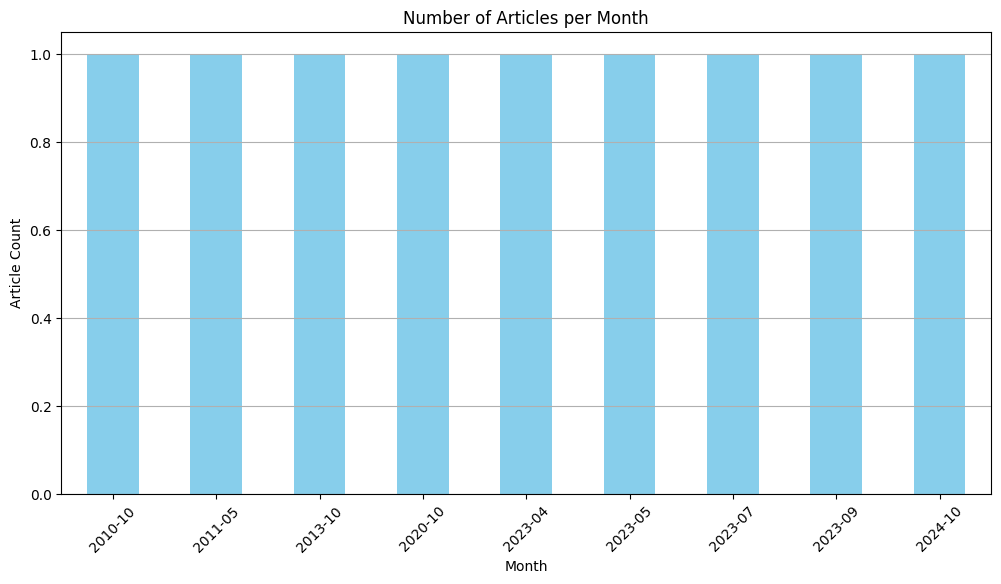

Successfully created a plot of articles per month
Thought: Now we'll proceed to visualize article trends


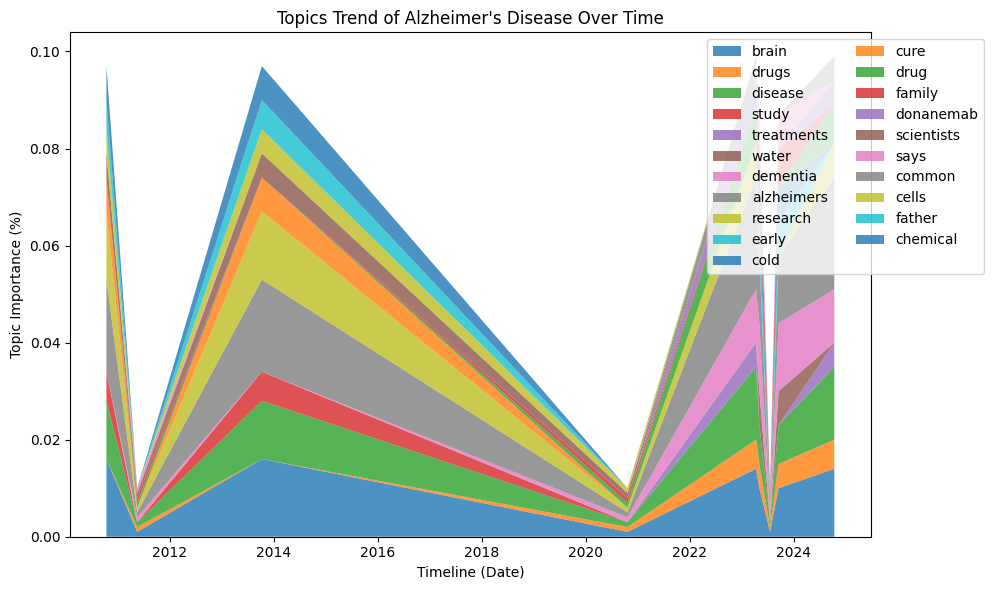

Successfully created a plot of article trends
Checking the final summary...
Thought: Now I’ve got the final answer.
FINISHED CHAIN
Correct Response:
##  The Global Pursuit of Alzheimer's Solutions: A Spatiotemporal Analysis of Research Efforts

This synthesis examines the global research landscape of Alzheimer's disease, drawing insights from recent and historical research efforts. The analysis reveals a surge in Alzheimer's research in the UK, particularly in recent years, focusing on both drug development and understanding the disease's complex mechanisms. 

**Key Findings:**

* **UK as a Hub:** Multiple articles highlight the UK's prominent role in Alzheimer's research, with active research centers in London, Edinburgh, Bristol, and Cardiff. 
* **Drug Development:** Significant focus on drug development, with articles discussing recent advances in potential treatments like donanemab, alongside ongoing efforts to identify new targets and therapies. 
* **Early Intervention:**  A growi

In [92]:
# Configure the Gemini API with the provided API key
api_key = GEMINI_API_KEY
genai.configure(api_key=api_key)

# Define the user input question related to Alzheimer's disease
user_input = "Can you help me to know something new about Alzheimer’s disease cure?"
model = genai.GenerativeModel("gemini-1.5-flash")

# Create a prompt to extract two keywords from the user input for searching articles
prompt = (
    "You have to decompose the user input into a sentence which has 2 major keywords, nothing else, "
    "that will help extract relevant URLs for articles related to Alzheimer's Disease. "
    "These keywords should be used to inform a search query that can be passed to the URL extraction function. "
    f"User input: {user_input} just give me 2 words you have can answer in 2 words nothing else"
)

# Generate content using the model based on the prompt
response = model.generate_content(prompt)

# Extract the generated keywords for the search query
content = response.candidates[0].content.parts[0].text
print(f"Extracted search query: {content}")
print(f"Thought: I need to use the tool “Search and Save news” to find answers to {user_input}")

# Extract URLs of articles related to the keywords and save them locally
print("Extracting URLs and saving locally")
search_news(content, GOOGLE_API_KEY, SEARCH_ENGINE_ID)

# Check if URLs were successfully extracted and saved
if os.path.exists('extracted_urls.txt'):
    print("URLs extracted and saved successfully.")
    print("Thought: Now that URLs are extracted, the next step is to save the articles")

    # Save the articles from the extracted URLs
    save_news('extracted_urls.txt')
    print("Articles saved successfully.")
else:
    print("Failed to download extracted URLs.")

# Check if articles were saved successfully for LDA extraction
if os.path.exists('articles.txt'):
    print("Thought: Now that articles have been saved, it's time to get LDA information from the articles")

    # Extract LDA information from the saved articles
    lda_from_articles('articles.txt')
    print("Successfully extracted LDA information from the articles and saved to a new file")
else:
    print("Failed to find articles.txt. LDA extraction will not be performed.")

# Check if the LDA information file exists for summarization
if os.path.exists('articles_with_lda.txt'):
    print("Thought: Now that LDA information has been extracted, it's time to summarize the articles")

    # Summarize the articles that contain LDA information
    initial_summarize('articles_with_lda.txt')
    print("Successfully summarized the articles and saved to a new file")
else:
    print("Failed to find articles_with_lda.txt. Summarization will not be performed.")

# Check if summaries exist for further information extraction
if os.path.exists('summaries.txt'):
    print("Thought: Now that the articles have been summarized, it's time to extract date, lda and locations separately")

    # Extract relevant information like dates, LDA, and locations from summaries
    extract_info('summaries.txt')
    print("Successfully extracted date, lda and locations from the articles and saved to a new file")
else:
    print("Failed to find summaries.txt. Information extraction will not be performed.")

# Check if extracted information file exists to combine summaries
if os.path.exists('extracted_info.txt'):
    print("Thought: Now that the information has been extracted, it's time to combine the summaries")

    # Combine the extracted information into a cohesive summary
    combined_summary('extracted_info.txt')
    print("Successfully combined the summaries and saved to a new file")

# Check if the combined summary exists to visualize locations
if os.path.exists('extracted_info.txt'):
    print("Thought: Now we'll proceed to build a map of the locations")

    # Visualize the locations extracted from the summaries on a world map
    visualize_locations('extracted_info.txt')
    print("Successfully created world map with important locations marked")
else:
    print("Failed to find combined_summary.txt. Map creation will not be performed.")

# Check if the extracted information file exists to visualize article counts
if os.path.exists('extracted_info.txt'):
    print("Thought: Now we'll proceed to visualize article counts per month")

    # Visualize the number of articles published per month
    visualize_article_counts('extracted_info.txt')
    print("Successfully created a plot of articles per month")
else:
    print("Plot creation will not be performed.")

# Check if the extracted information file exists to visualize article trends
if os.path.exists('extracted_info.txt'):
    print("Thought: Now we'll proceed to visualize article trends")

    # Visualize trends of topics over time using LDA data
    visualize_plot_trend('extracted_info.txt')
    print("Successfully created a plot of article trends")
else:
    print("Plot creation will not be performed.")

# Check if the final summary exists for verification
if os.path.exists('combined_summary.txt'):
    print("Checking the final summary...")
    print("Thought: Now I’ve got the final answer.")
    print("FINISHED CHAIN")

    # Check if the final summary adequately answers the user's question
    check_summary(user_input)
